# Train a NN for prediction aggregation

Follows same method as for xgbregressor in 4_post_hoc.ipynb: train a NN to predict participants' performance, then use the trained model to weigh test participants, then use that and the beta transformation to generate aggregate predcitions.

## Set up

Set up the code

In [1]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..')) # Add parent directory to path
sys.path.insert(0, module_path)

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Imports for xgb
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Imports for pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import StepLR

# Local imports
from src import process
from src import plot
from src import util
from src import models

data_path = process.DEFAULT_DATA_PATH

In [3]:
# Load data
blind_mode_df, estimates_df = process.load_and_process_results(
    fix_bad_rows=True, remove_bad_rows=True
)
blind_mode_feature_df = process.get_feature_df(blind_mode_df)
resolution_vector = process.get_target_df(df_format=False)
estimates_matrix = process.get_estimates_matrix(blind_mode_df)
brier_score = np.mean(np.square(estimates_matrix - resolution_vector), axis=1)
# markets_df = process.get_current_probs()
# blind_mode_df["brier_score"] = brier_score

In [4]:
# Create a new dataframe with the columns we want to use
columns_to_use = blind_mode_feature_df.columns.tolist()
blind_mode_df_pytorch = blind_mode_feature_df[columns_to_use]

# Split into train and test sets
X = blind_mode_df_pytorch.values
y = brier_score

# Convert nans to the mean
X_column_means = np.nanmean(X, axis=0)
X = np.nan_to_num(X, nan=X_column_means)

# Perform feature normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

## NN, based on similar approach to the XGBoost Regression

In [5]:
# Initialize and train the model
params = models.get_default_params()
params.hidden_layer_sizes = [100, 50, 10]
seed = 42
torch.manual_seed(seed)
print(f"Using device: {params.device}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, train_size=params.train_size, random_state=seed
)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, shuffle=True, batch_size=params.batch_size)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))
X_train, y_train = X_train.to(params.device), y_train.to(params.device)
X_test, y_test = X_test.to(params.device), y_test.to(params.device)

# Create the model
input_size = X_train.shape[1]
model = models.Net(input_size, params.hidden_layer_sizes)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=params.lr)
loss_function = nn.MSELoss()

model.train()
for epoch in range(params.n_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        # Backward pass
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch} loss: {loss.item()}")

# Evaluate the model
model.eval()

# Make test predictions
y_pred = []
for inputs, labels in test_loader:
    outputs = model(inputs)
    y_pred.extend(outputs.detach().numpy().flatten())
y_pred = np.array(y_pred)

print(f"PyTorch test MSE: {mean_squared_error(y_test.cpu(), y_pred)}")

Using device: cuda
Epoch 0 loss: 0.1370382308959961
Epoch 100 loss: 0.002070382237434387
Epoch 200 loss: 0.0024383291602134705
Epoch 300 loss: 0.002169874729588628
Epoch 400 loss: 0.003252501366659999
Epoch 500 loss: 0.0022759712301194668
PyTorch test MSE: 0.002425230573862791


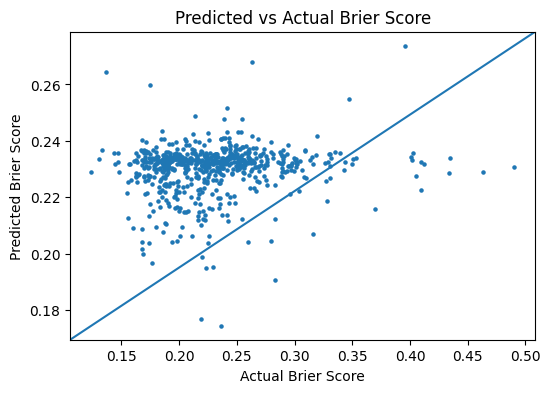

In [6]:
# Plot predictions against actual values
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.scatter(y_test.cpu(), y_pred, s=5)
ax.set_xlabel("Actual Brier Score")
ax.set_ylabel("Predicted Brier Score")
ax.set_title("Predicted vs Actual Brier Score")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.show()